# FastHugs + Language Modelling
> train a Huggingface language model from scratch and fine-tune a pretrained one, using fastai.

For an example of **text classification** using HuggingFace and fastai, have a look at my previous notebook [**here**](https://github.com/morganmcg1/fasthugs/blob/master/fasthugs_seq_classification.ipynb)

TL;DR
- Training a language model is great!

In [4]:
#hide
# CUDA ERROR DEBUGGING
# https://lernapparat.de/debug-device-assert/
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
#hide
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

from transformers import AutoModelWithLMHead, AutoModelForPreTraining, AutoTokenizer, AutoConfig #AutoModelForSequenceClassification
from splitters import *

import json

In [5]:
#hide
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
df = pd.read_csv(path/'texts.csv')

## FastHugs Tokenizer
This tokenizer wrapper is initialised with the pretrained HF tokenizer, you can also specify the max_seq_len if you want longer/shorter sequences. Given text it returns tokens and adds separator tokens depending on the model type being used.

In [58]:
class FastHugsTokenizer():
    """ 
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_name : model type set by the user
        max_seq_len : override default sequence length, typically 512 for bert-like models.
                           `transformer_tokenizer.max_len_single_sentence` and `transformer_tokenizer.max_len_sentences_pair` 
                           both account for the need to add additional special tokens, i.e. for RoBERTa-base 
                           max_len_single_sentence==510, leaving space for the 2 additional special tokens 
                           to be added for the model's default 512 positional embeddings
        pair : whether a single sentence (sequence) or pair of sentences are used
        
        NOTES:
            - `init` will have to be modified to enable sequence lengths larger than the tokenizer default
            - need to add case when pretrained==False
            - Pretrained==True will cut the sequence at the max length
            - Good functions in `tokenization_utils.py`
            - tokenizer.encode_plus or tokenizer.batch_encode_plus are great, but don't play nice with fastai multiprocessiing
            - https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus
            - encoded_dict=tokenizer.encode_plus(text=o, return_tensors="pt", max_length=tokenizer.max_len, pad_to_max_length=True)
        Returns:
            - Tokenized text, up to the max sequence length set by the user or the tokenzier default
    """
    def __init__(self, transformer_tokenizer=None, model_name='roberta', max_seq_len=None, 
                 pretrained=True, pair=False, **kwargs): 
        self.model_name, self.tok, self.max_seq_len=model_name, transformer_tokenizer, max_seq_len
        if pretrained:
            if self.max_seq_len:
                if pair: assert self.max_seq_len<=self.tok.max_len_sentences_pair, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_sentences_pair'
                else: assert self.max_seq_len<=self.tok.max_len_single_sentence, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_single_sentence'
            else:
                if pair: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_sentences_pair) 
                else: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_single_sentence)

    def do_tokenize(self, o:str):
        """Returns tokenized text, adds prefix space if needed, limits the maximum sequence length"""
        if 'roberta' in model_name: tokens=self.tok.tokenize(o, add_prefix_space=True)[:self.max_seq_len]
        else: tokens = self.tok.tokenize(o)[:self.max_seq_len]
        return tokens
    def __call__(self, items): 
        for o in items: yield self.do_tokenize(o)

In [59]:
class FastHugsModel(nn.Module):
    'Inspired by https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data'
    def __init__(self, transformer_cls, config_dict, n_class, pretrained=True):
        super(FastHugsModel, self).__init__()
        self.config = config_dict  
        self.config._num_labels = n_class
        # load model
        if pretrained: self.transformer = transformer_cls.from_pretrained(model_name, config=self.config)
        else: self.transformer = transformer_cls.from_config(config=self.config)
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) 
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

## The HuggingFace bit

### Define HuggingFace Model + Config
- `AutoModelForSequenceClassification` will define our model. When this is padded to the `FastHugsModel` class below then model will be instantiated and the weights downloaded (if you are using a pretrained model)
- `AutoConfig` will define the model architecture and settings
- `model_name` is the model architecture (and optionally model weights) you'd like to use.
    - Models tested: `bert-base-uncased`, `roberta-base`, `distilbert-base-cased`, `albert-base-v2`
    - You can find all of HuggingFace's models at [https://huggingface.co/models](https://huggingface.co/models), although not all of them are supported by `AutoModel`,`AutoConfig` and `AutoTokenizer`

In [12]:
model_name = 'roberta-base' 
#model_class = AutoModelForSequenceClassification
model_class = AutoModelWithLMHead #AutoModelForPreTraining
config_dict = AutoConfig.from_pretrained(model_name)

## Train your own Tokenizer

In [60]:
path = untar_data(URLs.IMDB_SAMPLE)
# model_path = Path('models')
# df = pd.read_csv(path/'texts.csv')
path

Path('/home/morgan/.fastai/data/imdb_sample')

In [40]:
#from pathlib import Path
from tokenizers import ByteLevelBPETokenizer

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=str(path/'texts.csv'), vocab_size=52000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

In [41]:
tokenizer_vocab=tokenizer.get_vocab()
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
len(tokenizer_vocab_ls), tokenizer_vocab_ls

(19560,
 ['<s>',
  '<pad>',
  '</s>',
  '<unk>',
  '<mask>',
  '!',
  '"',
  '#',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '*',
  '+',
  ',',
  '-',
  '.',
  '/',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  ';',
  '<',
  '=',
  '>',
  '?',
  '@',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  '[',
  '\\',
  ']',
  '^',
  '_',
  '`',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  '{',
  '|',
  '}',
  '~',
  '¡',
  '¢',
  '£',
  '¤',
  '¥',
  '¦',
  '§',
  '¨',
  '©',
  'ª',
  '«',
  '¬',
  '®',
  '¯',
  '°',
  '±',
  '²',
  '³',
  '´',
  'µ',
  '¶',
  '·',
  '¸',
  '¹',
  'º',
  '»',
  '¼',
  '½',
  '¾',
  '¿',
  'À',
  'Á',
  'Â',
  'Ã',
  'Ä',
  'Å',
  'Æ',
  'Ç',
  'È',
  'É',


In [38]:
# from tokenizers.processors import BertProcessing

# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("</s>", tokenizer.token_to_id("</s>")),
#     ("<s>", tokenizer.token_to_id("<s>")),
# )
# tokenizer.enable_truncation(max_length=512)

In [34]:
# tokenizer_vocab=tokenizer.get_vocab()
# tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
# len(tokenizer_vocab_ls), tokenizer_vocab_ls

In [57]:
#print(tokenizer.encode("hey how are you? was this any good?"))
gg=tokenizer.encode('hey how are you? was this any good?')
gg.tokens

['hey', 'Ġhow', 'Ġare', 'Ġyou', '?', 'Ġwas', 'Ġthis', 'Ġany', 'Ġgood', '?']

### HuggingFace Config changes
Some config settings can be changed even when using pretrained weights. For example in the `FastHugsModel` class below `_num_labels` is set when the model (pretrained or not) is instantiated, depending on how many classes you have in your dataloader.

When creating a **non-pretrained** model you can load a config with:

> `config_dict = AutoConfig.for_model(model_name)`

Alternatively you could load a pretrained config and modify that. For example if your are **not** using a pretrained model you can change the size of your input embeddings by changing `config_dict.max_position_embeddings = 1024`. (This won't work when using pretrained models as the pre-trained weights need the default `max_position_embeddings` size).

### HuggingFace Tokenizer & Vocab
- `AutoTokenizer` will load our tokenizer and enable us grab our vocab

fastai expects `vocab` to be a list, however HuggingFace's `get_vocab` returns a `token : index` dict. We need to convert this dict to a list to be able to use it in fastai

In [61]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_vocab=tokenizer.get_vocab() 
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
len(tokenizer_vocab_ls)

50265

#### Special Tokens
Its always good to know what special tokens your tokenizer needs, lets have a look:

In [62]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

## The Fastai bit
### Get fastai model splitter function
In order to be able to fine-tune our classifier head we need to first split the HuggingFace model's classifier head from the body. These functions are dependent on the specific architecture and can be found in `splitter.py` of this repo

In [63]:
splitter_nm = model_name.split('-')[0] + '_cls_splitter'
model_splitter = splitters[splitter_nm]

### `fasthugstok` and our `tok_fn`
Lets incorporate the `tokenizer` from HuggingFace into fastai-v2's framework by specifying a function called `fasthugstok` that we can then pass on to `Tokenizer.from_df`. (Note `.from_df` is the only method I have tested)

#### Max Seqence Length
`max_seq_len` is the longest sequece our tokenizer will output. We can also the max sequence length for the tokenizer by changing `max_seq_len`. It uses the tokenizer's default, typically `512`. `1024` or even `2048` can also be used depending on your GPU memory. Note when using pretrained models you won't be able to use a `max_seq_len` larger than the default. 

In [64]:
max_seq_len = None  
sentence_pair=False

fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer=tokenizer, model_name=model_name, 
                      max_seq_len=max_seq_len, sentence_pair=sentence_pair)

Set up fastai's `Tokenizer.from_df`, we pass `rules=[]` to override fastai's default text processing rules

In [65]:
fastai_tokenizer = Tokenizer.from_df(text_cols='text', res_col_name='text', tok_func=fasthugstok, 
                                     rules=[], post_rules=[])

In [66]:
fastai_tokenizer.rules

[]

### Add Special Tokens
BERT-like transformers require special tokens to be added to the sequence, depending on the task.

In [30]:
class SpecialClsTokens(Transform):
    "Add special token_ids to the numericalized tokens for Sequence Classification"
    def __init__(self, tokenizer):
        self.tok=tokenizer
    def encodes(self, o):
        return(TensorText(self.tok.build_inputs_with_special_tokens(list(o))))

#### Tests

In [31]:
txt=["If you want the real version of this over blown American clown act, watch William Wylers' 1944 version - the true story of the 'Memphis Belle'. It's amazing what Hollywood will do to distort history and mock its' veterans, all for a buck. Well it must be the American way! Younger viewers will be beguiled by the nonsense, however older viewers with some sense of history will recognize this movie for what it is worth. Don't waste your time! However, if you don't want the truth, then put your mind in neutral and watch this movie."]

In [47]:
fht=FastHugsTokenizer(transformer_tokenizer=tokenizer, model_name='roberta', max_seq_len=None, 
                 pretrained=True, pair=False)
tokenized_text = next(fht(txt))

In [41]:
# Test Numericalize working the same as HuggingFace
test_eq(Numericalize(vocab=tokenizer_vocab_ls)(tokenized_text),
        TensorText(tokenizer.convert_tokens_to_ids(tokenized_text)))

In [42]:
# Check that additional tokens are being added
pre_special=Numericalize(vocab=tokenizer_vocab_ls)(tokenized_text)
with_special=SpecialClsTokens(tokenizer)(pre_special)
print(f'pre_special length: {len(pre_special)}, with_special length: {len(with_special)}')

pre_special length: 118, with_special length: 120


## MLM

In [73]:
path = untar_data(URLs.IMDB)
files = get_text_files(path, folders = ['train', 'test', 'unsup'])
txts = L(o.open().read() for o in files[:2000])

In [75]:
txts[0]

"If you want the real version of this over blown American clown act, watch William Wylers' 1944 version - the true story of the 'Memphis Belle'. It's amazing what Hollywood will do to distort history and mock its' veterans, all for a buck. Well it must be the American way! Younger viewers will be beguiled by the nonsense, however older viewers with some sense of history will recognize this movie for what it is worth. Don't waste your time! However, if you don't want the truth, then put your mind in neutral and watch this movie."

In [85]:
inputs = torch.tensor(tokenizer.encode(txts[:200][0], add_special_tokens=True)).unsqueeze(0)  # Batch size 1
print(inputs.size(), inputs)

torch.Size([1, 120]) tensor([[    0,   318,    47,   236,     5,   588,  1732,     9,    42,    81,
         12315,   470, 21068,  1760,     6,  1183,  2897,   305,  4360,   268,
           108, 26447,  1732,   111,     5,  1528,   527,     9,     5,   128,
         35038, 42377, 17046,  2652,    85,    18,  2770,    99,  3049,    40,
           109,     7, 39841,   750,     8, 16177,    63,   108,  4823,     6,
            70,    13,    10, 13182,     4,  2647,    24,   531,    28,     5,
           470,   169,   328, 34064,  5017,    40,    28, 21422,   257,  6691,
            30,     5, 20175,     6,   959,  2530,  5017,    19,   103,  1472,
             9,   750,    40,  5281,    42,  1569,    13,    99,    24,    16,
           966,     4,  1599,    75,  3844,   110,    86,   328,   635,     6,
           114,    47,   218,    75,   236,     5,  3157,     6,   172,   342,
           110,  1508,    11,  7974,     8,  1183,    42,  1569,     4,     2]])


In [ ]:
mlm_probability = 0.15

if tokenizer.mask_token is None:
    raise ValueError(
        "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
    )

labels = inputs.clone()

In [89]:
def mask_tokens(inputs, tokenizer):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """

    mlm_probability = 0.15
    
    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability) #args.mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [90]:
inputs, labels = mask_tokens(inputs, tokenizer)

In [92]:
inputs, labels

(tensor([[    0,   318,    47,   236,     5,   588,  1732,     9,    42, 50264,
          12315, 50264, 21068,  1760,     6,  1183,  2897,   305,  4360,   268,
            108, 26447,  1732,   111,     5,  1528,   527,     9,     5,   128,
          35038, 42377, 50264, 50264, 50264,    18, 50264,    99,  3049,    40,
            109,     7, 39841,   750,     8, 16177,    63,   108,  4823,     6,
             70,    13,    10, 13182,     4,  2647,    24,   531,    28,     5,
          50264,   169,   328, 34064,  5017,    40,    28, 21422, 50011, 50264,
             30,     5, 20175,     6,   959,  2530,  5017,    19, 50264,  1472,
              9,   750,    40,  5281,    42,  1569,    13,    99,    24, 50264,
            966,     4,  1599,    75,  3844,   110,    86, 50264,   635,     6,
            114,    47,   218, 50264,   236,     5,  3157,     6,   172,   342,
            110,  1508,    11,  7974,     8,  1183,    42,  1569,     4,     2]]),
 tensor([[ -100,  -100,  -100,  -100,

In [ ]:
model = model_class.from_config(config_dict)

In [94]:
attention_mask = (inputs!=1).type(inputs.type()) 
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [95]:
#  def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         token_type_ids=None,
#         position_ids=None,
#         head_mask=None,
#         inputs_embeds=None,
#         masked_lm_labels=None,

o = model(input_ids=inputs,attention_mask=attention_mask,masked_lm_labels=labels)
o

(tensor(11.0393, grad_fn=<NllLossBackward>),
 tensor([[[-0.0736,  0.8163, -1.4481,  ..., -0.4825, -0.2726, -0.0789],
          [-0.2989,  0.1606, -0.0234,  ..., -0.3260, -0.7045, -0.2801],
          [-1.0612,  0.6088, -0.2831,  ..., -0.0172, -1.4549, -0.0567],
          ...,
          [ 0.5030,  0.5280, -0.9317,  ..., -0.3854, -0.3387, -0.5176],
          [-0.1144,  0.6011, -0.2035,  ..., -0.5755, -0.0133,  0.2233],
          [ 0.1410,  0.6001, -0.8336,  ..., -1.0699, -0.2284, -0.2142]]],
        grad_fn=<AddBackward0>))

In [105]:
ii = model.roberta(inputs);
ii[0].size(),ii[1].size(), ii[1], ii

(torch.Size([1, 120, 768]),
 torch.Size([1, 768]),
 tensor([[-2.3607e-01,  1.2323e-01, -2.2271e-01, -5.5239e-02, -2.2499e-01,
          -5.4239e-01, -3.7654e-01, -1.9936e-01, -7.3116e-01,  9.2172e-02,
          -2.9842e-01,  4.4682e-01, -3.0518e-01,  5.3400e-01,  8.6748e-02,
          -6.9573e-01, -4.8287e-01,  5.7234e-01,  2.6404e-01,  5.1088e-01,
          -5.4854e-01,  4.6491e-01,  5.6210e-02, -1.6748e-01, -3.1243e-01,
          -4.5033e-01, -2.7512e-01, -5.6313e-01,  2.9044e-01, -6.7704e-01,
           1.8282e-01, -3.4187e-01, -8.5064e-01,  3.4513e-01,  5.3218e-01,
          -2.4661e-01,  5.5416e-01,  9.9398e-03,  2.4746e-02, -5.7272e-01,
           8.3035e-01,  4.4868e-01, -6.2770e-01,  9.5502e-01, -5.8525e-01,
           7.1525e-01,  7.1599e-01, -1.6090e-01,  4.2731e-01,  2.0493e-01,
           3.2232e-01, -2.2603e-01, -5.4932e-01,  1.0421e-01,  6.0206e-02,
           6.3284e-01, -4.8334e-01,  1.2078e-01, -6.4439e-01, -1.4928e-01,
          -3.2728e-01, -3.5859e-02,  1.3950e-01, 

In [107]:
??model.roberta

In [ ]:
model.lm_head

In [114]:
??model

In [98]:
len(o), o[0].size(), o[1].size()

(2,
 torch.Size([]),
 torch.Size([1, 120, 50265]),
 tensor(11.0393, grad_fn=<NllLossBackward>))

In [111]:
outputs = model.roberta(
            inputs,
            attention_mask=attention_mask,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
        )
outputs[0].size(),outputs[1].size()

(torch.Size([1, 120, 768]), torch.Size([1, 768]))

In [134]:
labels

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,    81,
          -100,   470,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100, 17046,  2652,    85,  -100,  2770,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,    10,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           470,  -100,  -100,  -100,  -100,  -100,  -100,  -100,   257,  6691,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,   103,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,    16,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,   328,  -100,  -100,
          -100,  -100,  -100,    75,  -100,  -100,  -100,  -100,   172,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100]])

ddddd

fff

hey i'M NEW

In [132]:
outputs = model.roberta(
            inputs,
            attention_mask=attention_mask,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
        )

sequence_output = outputs[0]

prediction_scores = model.lm_head(sequence_output)

outputs = (prediction_scores,) + outputs[2:]  # Add hidden states and attention if they are here

if labels is not None:
    loss_fct = nn.CrossEntropyLoss()
    masked_lm_loss = loss_fct(prediction_scores.view(-1, model.config.vocab_size), labels.view(-1))
    print(masked_lm_loss)
    outputs = (masked_lm_loss,) + outputs

# return outputs  # (masked_lm_loss), prediction_scores, (hidden_states), (attentions)

tensor(10.9034, grad_fn=<NllLossBackward>)


In [ ]:
class LMLoss()

In [131]:
masked_lm_loss.size()

torch.Size([])

In [133]:
outputs[0]

tensor(10.9034, grad_fn=<NllLossBackward>)

In [130]:
outputs[0].size(), outputs[1].size()

(torch.Size([]), torch.Size([1, 120, 50265]))

In [126]:
prediction_scores.view(-1, model.config.vocab_size).size(), labels.view(-1).size()

(torch.Size([120, 50265]), torch.Size([120]))

## Setup Dataloaders
### Create Dataset
Lets add our custom tokenizer function (`tok_fn`) and `transformer_vocab` here

In [44]:
# class DumTfm(Transform):
#     "Add special token_ids to the numericalized tokens for Sequence Classification"
#     def __init__(self, tokenizer):
#         self.tok=tokenizer
#     def encodes(self, o):
#         return o
#     def decodes(self, o):
#         return self.tok.decode(o.tolist())

In [77]:
??Categorize

In [45]:
splits = ColSplitter()(df)
x_tfms = [attrgetter("text"), fastai_tokenizer, Numericalize(vocab=tokenizer_vocab_ls), SpecialClsTokens(tokenizer)]

#x_tfms = [attrgetter("text"), fastai_tokenizer, DumTfm(tokenizer)]
dsets = Datasets(df, splits=splits, tfms=[x_tfms, [attrgetter("label"), Categorize()]], dl_type=SortedDL)

In [ ]:
outputs = model(inputs, masked_lm_labels=labels) 

In [ ]:
class FastHugsModel(nn.Module):
    'Inspired by https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data'
    def __init__(self, transformer_cls, config_dict, n_class, pretrained=True):
        super(FastHugsModel, self).__init__()
        self.config = config_dict  
        self.config._num_labels = n_class
        # load model
        if pretrained: self.transformer = transformer_cls.from_pretrained(model_name, config=self.config)
        else: self.transformer = transformer_cls.from_config(config=self.config)
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) 
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

In [ ]:
transformer_cls.from_pretrained(model_name, config=self.config)

In [82]:
model = model_class.from_config(config_dict)

In [84]:
model??

In [ ]:
masked_lm_labels

In [ ]:
outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        sequence_output = outputs[0]
        prediction_scores = self.lm_head(sequence_output)

        outputs = (prediction_scores,) + outputs[2:]  # Add hidden states and attention if they are here

        if masked_lm_labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            outputs = (masked_lm_loss,) + outputs

        return outputs  # (masked_lm_loss), prediction_scores, (hidden_states), (attentions)

In [79]:
??Categorize

### Max len fixing

In [ ]:
# https://github.com/huggingface/transformers/blob/a21d4fa410dc3b4c62f93aa0e6bbe4b75a101ee9/src/transformers/tokenization_utils.py#L1775

# add_special_tokens=True
    
    
# pair = bool(pair_ids is not None)
# len_ids = len(ids)
# len_pair_ids = len(pair_ids) if pair else 0

# # Load from model defaults
# if return_token_type_ids is None:
#     return_token_type_ids = "token_type_ids" in self.model_input_names
# if return_attention_mask is None:
#     return_attention_mask = "attention_mask" in self.model_input_names

# encoded_inputs = {}

# # Truncation: Handle max sequence length
# total_len = len_ids + len_pair_ids + (self.num_special_tokens_to_add(pair=pair) if add_special_tokens else 0)

# if max_length and total_len > max_length:
#     ids, pair_ids, overflowing_tokens = self.truncate_sequences(
#         ids,
#         pair_ids=pair_ids,
#         num_tokens_to_remove=total_len - max_length,
#         truncation_strategy=truncation_strategy,
#         stride=stride,
#     )
#     if return_overflowing_tokens:
#         encoded_inputs["overflowing_tokens"] = overflowing_tokens
#         encoded_inputs["num_truncated_tokens"] = total_len - max_length

# # Add special tokens
# if add_special_tokens:
#     sequence = self.build_inputs_with_special_tokens(ids, pair_ids)
#     token_type_ids = self.create_token_type_ids_from_sequences(ids, pair_ids)
# else:
#     sequence = ids + pair_ids if pair else ids
#     token_type_ids = [0] * len(ids) + ([1] * len(pair_ids) if pair else [])

### What to do with `token_type_ids`

In [46]:
#token_type_ids = self.create_token_type_ids_from_sequences(ids, pair_ids)

### Padding
We need to make sure our padding is done correctly as some transformer models prefer padding on the left while others prefer it on the right. `tokenizer.padding_side` will tell us which side is correct. e.g., BERT, Roberta prefers padding to the right, so we set `pad_first=False`

In [37]:
def transformer_padding(tokenizer=None, max_seq_len=None, sentence_pair=False): 
    if tokenizer.padding_side == 'right': pad_first=False
    else: pad_first=True
    max_seq_len = ifnone(max_seq_len, tokenizer.max_len) 
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=tokenizer.pad_token_id, seq_len=max_seq_len)

### Dataloaders

In [48]:
bs = 4
padding=transformer_padding(tokenizer)
dls = dsets.dataloaders(bs=bs, before_batch=[padding])

#### Check our batch
We can see our special RoBERTa tokens (`'<s>'`, `'</s>'`), which translate to `0, 2` in its vocab, have been added to the start and end of each sequence in the batch. Your can look at these indices in `tokenizer.get_vocab()` to confirm

In [49]:
o=dls.one_batch(); o[0].size(), o[1].size(), o[0]

(torch.Size([4, 512]),
 torch.Size([4]),
 TensorText([[    0,    38,    21,  ...,    54,     5,     2],
         [    0,   286,   167,  ..., 49069,  3809,     2],
         [    0,    38,  3805,  ...,    10,   356,     2],
         [    0,  4913,  3748,  ...,     7,    28,     2]], device='cuda:0'))

In [50]:
dls.show_batch(max_n=3, trunc_at=60)

,text,category
0,"<s> ĠI Ġwas Ġfortunate Ġenough Ġto Ġmeet ĠGeorge ĠPal Ġ( and Ġstill Ġhave Ġmy ĠDS : TM OB Ġposter Ġaut ographed Ġby Ġhim ) Ġat Ġa Ġconvention Ġshortly Ġafter Ġthe Ġrelease , Ġand Ġasked Ġhim Ġwhy Ġhe Ġchose Ġto Ġdo Ġthe Ġfilm Ġ"" camp "". ĠBefore Ġhe Ġcould Ġanswer , Ġtwo Ġstudio Ġfl acks Ġintercepted Ġand Ġlect ured Ġme Ġon",negative
1,"<s> ĠI Ġdo Ġmiss Ġthe Ġcompany ĠVest ron , Ġthey Ġsure Ġhad Ġtheir Ġfinger Ġon Ġthe Ġpulse Ġof Ġunique Ġand Ġunusual Ġcinema Ġback Ġin Ġthe Ġ1980 s . ĠThis Ġis Ġvery Ġapparent Ġwith Ġthe Ġastonishing ĠPaper house , Ġa Ġfilm Ġthat Ġtouches Ġme Ġdeeply Ġeach Ġand Ġevery Ġtime ĠI Ġwatch Ġit .< br Ġ/ >< br Ġ/> The Ġidea Ġof",positive
2,"<s> ĠAfter Ġthe Ġfailure Ġof Ġ"" The ĠCrus ades "" Ġat Ġthe Ġbox Ġoffice , ĠCecil ĠB . ĠDe M ille Ġstopped Ġdoing Ġfilms Ġabout Ġnon - American Ġhistory . ĠHis Ġfilms Ġfor Ġthe Ġnext Ġthirteen Ġyears Ġwere Ġabout Ġour Ġhistory Ġfrom ĠJean ĠLaf itte Ġto ĠWorld ĠWar ĠII Ġ( Dr . ĠWas sell ). ĠThe Ġfirst Ġin Ġorder Ġof",positive


### [NOT WORKING WITH EXTERNAL ADDITION OF SPECIAL TOKENS]
### (Alternatively) Factory dataloader
Here we set:
- `tok_tfm=tok_fn` to use our HF tokenizer
- `text_vocab=transformer_vocab` to load our pretrained vocab
- `before_batch=transformer_padding(transformer_tokenizer)` to use our custom padding function 

In [55]:
# cls=SpecialClsTokens(tokenizer)

# # Factory
# fct_dls = TextDataLoaders.from_df(df, text_col="text", tok_tfm=fastai_tokenizer, text_vocab=tokenizer_vocab_ls,
#                               before_batch=[padding],
#                               #item_tfms=[cls],
#                               label_col='label', valid_col='is_valid', bs=bs)
# fct_dls.show_batch(max_n=3, trunc_at=60)

In [52]:
#o=fct_dls.one_batch(); o[0].size(), o[1].size(), o[0]

## Create our learner

In [51]:
opt_func = partial(Adam, decouple_wd=True)
loss = LabelSmoothingCrossEntropy()

fasthugs_model = FastHugsModel(transformer_cls=model_class, config_dict=config_dict, n_class=dls.c, pretrained=True)

learn = Learner(dls, fasthugs_model, opt_func=opt_func, splitter=model_splitter, 
                loss_func=loss, metrics=[accuracy]).to_fp16()

### Stage 1 training
Lets freeze the model backbone and only train the classifier head. `freeze_to(1)` means that only the classifier head is trainable

In [52]:
learn.freeze_to(1)  

In [53]:
learn.summary()

FastHugsModel (Input shape: ['4 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            4 x 512 x 768        38,603,520 False     
________________________________________________________________
Embedding            4 x 512 x 768        394,752    False     
________________________________________________________________
Embedding            4 x 512 x 768        768        False     
________________________________________________________________
LayerNorm            4 x 512 x 768        1,536      False     
________________________________________________________________
Dropout              4 x 512 x 768        0          False     
________________________________________________________________
Linear               4 x 512 x 768        590,592    False     
________________________________________________________________
Linear               4 x 512 x 768        590,592    False     
_________________________________________________________

Lets find a learning rate to train our classifier head

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=0.03981071710586548)

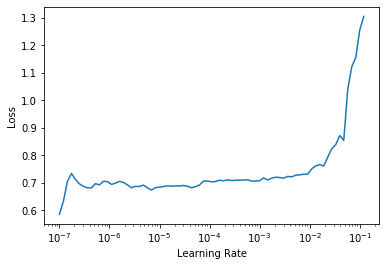

In [54]:
learn.lr_find(suggestions=True)

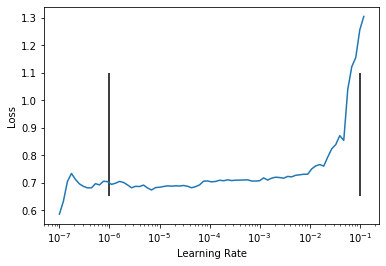

In [55]:
learn.recorder.plot_lr_find()
plt.vlines(9.999e-7, 0.65, 1.1)
plt.vlines(0.10, 0.65, 1.1)

In [56]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.723234,0.706531,0.535000,00:07
1,0.608959,0.579816,0.780000,00:07
2,0.536796,0.553176,0.835000,00:07


In [57]:
learn.save('roberta-fasthugs-stg1-1e-3')

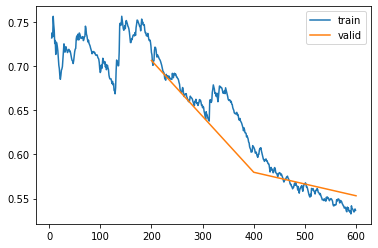

In [58]:
learn.recorder.plot_loss()

### Stage 2 - Unfreeze and train some more
And now lets train the full model with differential learning rates

In [59]:
learn.unfreeze()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

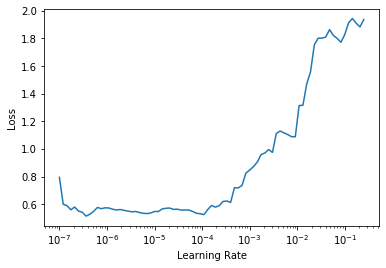

In [60]:
learn.lr_find(suggestions=True)

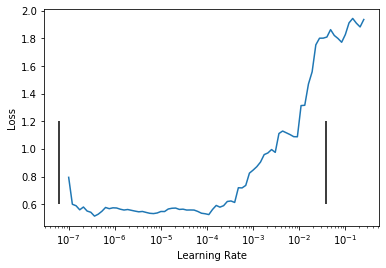

In [61]:
learn.recorder.plot_lr_find()
plt.vlines(6.30e-8, 0.6, 1.2)
plt.vlines(0.039, 0.6, 1.2)

In [62]:
learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.480574,0.409219,0.890000,00:31
1,0.340219,0.364467,0.890000,00:31
2,0.285851,0.371014,0.915000,00:31


In [63]:
learn.save('roberta-fasthugs-stg2-3e-5')

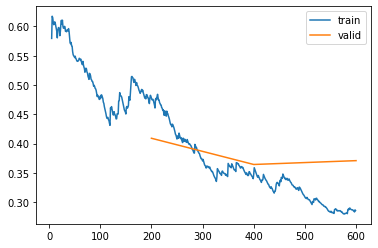

In [64]:
learn.recorder.plot_loss()

## Lets Look at the model's predictions

In [65]:
learn.predict("This was a really good movie, i loved it")

('positive', tensor(1), tensor([0.0587, 0.9413]))

In [66]:
from fastai2.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

In [67]:
interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,"<s> ĠIn Ġ17 th ĠCentury ĠJapan , Ġthere Ġlived Ġa Ġsamurai Ġwho Ġwould Ġset Ġthe Ġstandard Ġfor Ġthe Ġages . ĠHis Ġname Ġwas ĠMay eda . ĠHe Ġis Ġsent Ġon Ġan Ġepic Ġjourney Ġacross Ġthe Ġworld Ġto Ġacquire Ġ5 , 000 Ġmus cats Ġfrom Ġthe ĠKing Ġof ĠSpain . ĠWhilst Ġat Ġsea Ġa Ġviolent Ġstorm Ġswall ows Ġtheir Ġprecious Ġgold Ġintended Ġto Ġbuy Ġthe Ġweapons Ġand Ġalmost Ġtakes Ġtheir Ġlives . ĠMay eda Ġmust Ġbattle Ġall Ġodds Ġto Ġsurvive Ġand Ġthe Ġsecure Ġthe Ġfate Ġof Ġhis Ġbeloved ĠJapan . ĠShogun ĠMay eda Ġis Ġa Ġmulti Ġmillion Ġdollar Ġaction Ġadventure Ġepic Ġset Ġacross Ġthree Ġcontinents .< br Ġ/ >< br Ġ/> Star ring Ġcinema Ġlegends ĠSho ĠKos ugi Ġ( T ench u : ĠStealth ĠAssassins ), ĠChristopher ĠLee Ġ( Star ĠWars , ĠLord Ġof Ġthe ĠRings ĠTrilogy ), ĠJohn ĠRh ys ĠDavies Ġ( Lord Ġof Ġthe ĠRings ĠTrilogy , ĠIndiana ĠJones",negative,positive,0.9492946267127991,2.8352389335632324
1,"<s> ĠIn Ġorder Ġto Ġhold Ġthe Ġpublic 's Ġattention Ġfor Ġthree Ġhours , Ġwe Ġwere Ġtreated Ġnot Ġso Ġmuch Ġto Ġa Ġfamily 's Ġr omp Ġthrough Ġfour Ġgenerations Ġand Ġ120 Ġyears Ġof ĠHungarian Ġhistory , Ġas Ġto Ġsexual Ġlia isons Ġwith Ġa Ġsister , Ġa Ġsister - in - law Ġand Ġother Ġadul ter ies . ĠOh Ġyes , Ġthere Ġwas Ġalso Ġa Ġtotally Ġgrat uitous Ġrape . ĠHaving Ġsaid Ġall Ġthis , Ġthe Ġfirst Ġstory Ġof Ġthe Ġrelationship Ġamong Ġthe Ġchildren Ġof Ġthe Ġpatriarch Ġwas Ġfresh Ġand Ġsens ual Ġ- Ġthanks Ġto ĠJennifer ĠEh le . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>",negative,positive,0.9127477407455444,2.3215689659118652
2,"<s> ĠThis Ġmovie Ġis Ġhorrible - Ġin Ġa Ġ' so Ġbad Ġit 's Ġgood ' Ġkind Ġof Ġway .< br Ġ/ >< br Ġ/> The Ġstoryline Ġis Ġre h ashed Ġfrom Ġso Ġmany Ġother Ġfilms Ġof Ġthis Ġkind , Ġthat ĠI 'm Ġnot Ġgoing Ġto Ġeven Ġbother Ġdescribing Ġit . ĠIt 's Ġa Ġsword / s or cery Ġpicture , Ġhas Ġa Ġkid Ġhoping Ġto Ġrealize Ġhow Ġimportant Ġhe Ġis Ġin Ġthis Ġworld , Ġhas Ġa Ġ"" nom adic "" Ġadventurer , Ġan Ġevil Ġaide / s orce rer , Ġa Ġprincess , Ġa Ġhairy Ġcreature .... you Ġget Ġthe Ġpoint .< br Ġ/ >< br Ġ/> The Ġfirst Ġtime ĠI Ġcaught Ġthis Ġmovie Ġwas Ġduring Ġa Ġvery Ġharsh Ġwinter . ĠI Ġdon 't Ġknow Ġwhy ĠI Ġdecided Ġto Ġcontinue Ġwatching Ġit Ġfor Ġan Ġextra Ġfive Ġminutes Ġbefore Ġturning Ġthe Ġchannel , Ġbut Ġwhen ĠI Ġcaught Ġsite Ġof ĠGulf ax",positive,negative,0.9033368229866028,2.2247798442840576
